### Standard CNN-LSTM Model with feature engineered data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, BatchNormalization, MaxPooling1D, Input
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import display, HTML
import lime.lime_tabular
import shap

/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/Users/amalshar/Desktop/USD/Fall 2025/Data Analysis/Final Project/daily_2025_engineered_data.csv')

In [3]:
# Define features and target
FEATURES = ['CO', 'SO2', 'NO2', 'O3', 'PM25',
            'BarometricPressure', 'Temperature', 'WindResultant',
            'month', 'dayofweek', 'is_weekend', 'dayofyear',
            'CO_roll_3', 'NO2_roll_3', 'PM25_roll_3', 'O3_roll_3']

TARGET = 'DailyAQI'

X = df[FEATURES].values
y = df[TARGET].values.reshape(-1, 1)

In [4]:
# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [5]:
# Create 7-day lookback sequences
def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)
print("X_seq shape:", X_seq.shape)

X_seq shape: (91733, 7, 16)


In [6]:
# Train-test split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Train Shape: (73386, 7, 16)
Test Shape: (18347, 7, 16)


In [7]:
# Build CNN-LSTM model
model = Sequential([
    Input(shape=(time_steps, len(FEATURES))),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    LSTM(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 6, 64)          │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,761 (147.50 KB)

 Trainable params: 37,505 (146.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [8]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0153 - val_loss: 0.0022
Epoch 2/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 7.3033e-04 - val_loss: 6.9435e-04
Epoch 4/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.5194e-04 - val_loss: 5.1855e-04
Epoch 5/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4.7807e-04 - val_loss: 3.9388e-04
Epoch 6/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4.4359e-04 - val_loss: 4.9228e-04
Epoch 7/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4.0998e-04 - val_loss: 4.8558e-04
Epoch 8/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3.9237e-04 - val_loss: 2.3550e-04
Epoch 9/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.7169e-04 - val_loss: 3.8026e-04
Epoch 10/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.5988e-04 - val_loss: 2.7151e-04
Epoch 11/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.4

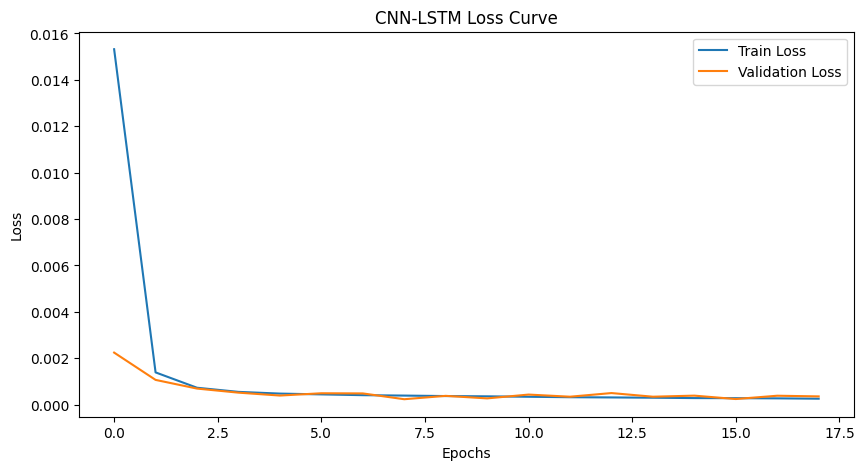

In [9]:
# Loss curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# Evaluation
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.3f}")

574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean Squared Error (MSE): 3090.551
Root Mean Squared Error (RMSE): 55.593
Mean Absolute Error (MAE): 20.708
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R²): 0.127


/var/folders/rx/gyp8p3vs42zfzk_hwhrnpcmw0000gn/T/ipykernel_61238/1400119000.py:10: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


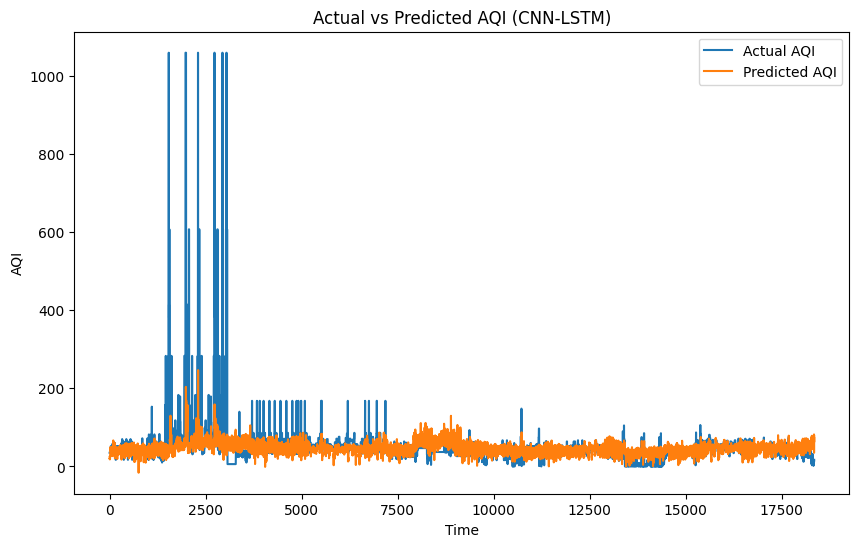

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual AQI')
plt.plot(y_pred, label='Predicted AQI')
plt.title('Actual vs Predicted AQI (CNN-LSTM)')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.legend()
plt.show()

574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
               Feature  Importance
4                 PM25    0.115790
3                   O3    0.020900
5   BarometricPressure    0.018404
2                  NO2    0.017480
9            dayofweek    0.017110
15           O3_roll_3    0.016800
14         PM25_roll_3    0.016634
8        

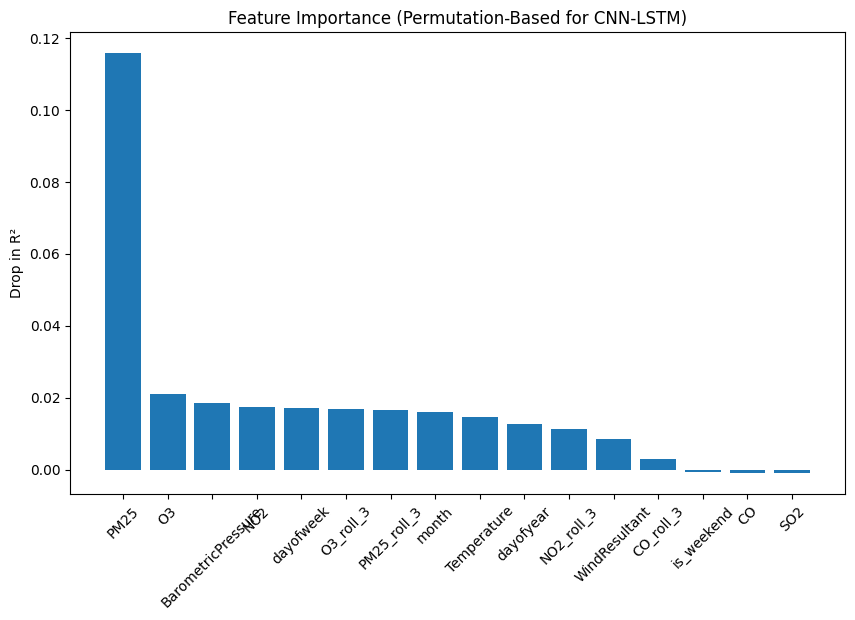

In [12]:
from sklearn.inspection import permutation_importance

def permutation_importance_cnn_lstm(model, X_test, y_true, metric=r2_score):
    baseline_pred = scaler_y.inverse_transform(model.predict(X_test))
    baseline_score = metric(y_true, baseline_pred)

    importances = {}
    for i, feat in enumerate(FEATURES):
        X_test_perm = X_test.copy()

        for t in range(time_steps):
            np.random.shuffle(X_test_perm[:, :, i])

        perm_pred = scaler_y.inverse_transform(model.predict(X_test_perm))
        perm_score = metric(y_true, perm_pred)
        importances[feat] = baseline_score - perm_score

    return importances

feat_importances = permutation_importance_cnn_lstm(model, X_test, y_true)

sorted_importances = pd.DataFrame(
    feat_importances.items(), columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

print(sorted_importances)

plt.figure(figsize=(10, 6))
plt.bar(sorted_importances['Feature'], sorted_importances['Importance'])
plt.title('Feature Importance (Permutation-Based for CNN-LSTM)')
plt.xticks(rotation=45)
plt.ylabel('Drop in R²')
plt.show()


In [17]:
# Flatten for LIME
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

feature_names = [f"{feat}_t-{i}" for i in range(time_steps) for feat in FEATURES]

def predict_wrapper(flat_data):
    reshaped = flat_data.reshape(-1, time_steps, len(FEATURES))
    return model.predict(reshaped).flatten()

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names,
    mode='regression'
)

# Create LIME explanation
i = 0
exp = lime_explainer.explain_instance(
    data_row=X_test_flat[i],
    predict_fn=predict_wrapper,
    num_features=10
)

# Display the result
try:
    from IPython.display import display, HTML
    display(HTML(exp.as_html()))
except ImportError:
    # Fallback to console output
    print("LIME Explanation:")
    for feature, weight in exp.as_list():
        print(f"{feature}: {weight}")
        
# save LIME explanation to HTML file
with open("exp12_lime_explanation.html", "w") as f:
    f.write(exp.as_html())


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 10%|█         | 1/10 [00:00<00:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 20%|██        | 2/10 [00:01<00:05,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 30%|███       | 3/10 [00:01<00:04,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 40%|████      | 4/10 [00:02<00:04,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|█████     | 5/10 [00:03<00:03,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 60%|██████    | 6/10 [00:04<00:02,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 70%|███████   | 7/10 [00:05<00:02,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 80%|████████  | 8/10 [00:05<00:01,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 90%|█████████ | 9/10 [00:06<00:00,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


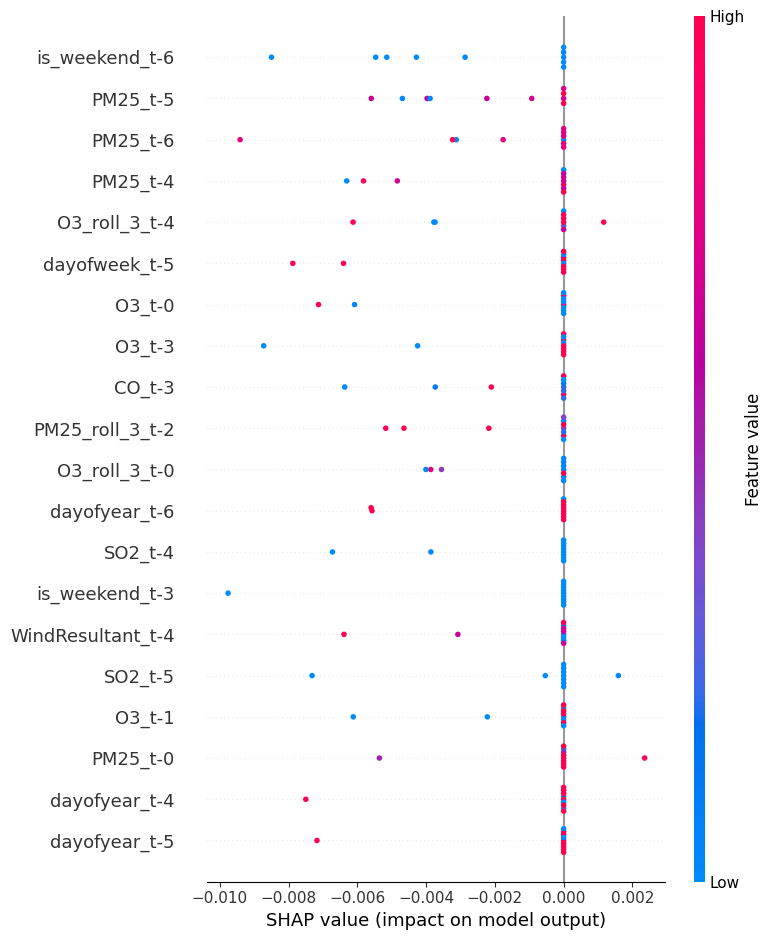

In [15]:
background = X_train_flat[:100]
test_samples = X_test_flat[:10]
shap_explainer = shap.KernelExplainer(predict_wrapper, background)
shap_values = shap_explainer.shap_values(test_samples, nsamples=100)

shap.summary_plot(shap_values, test_samples, feature_names=feature_names)
